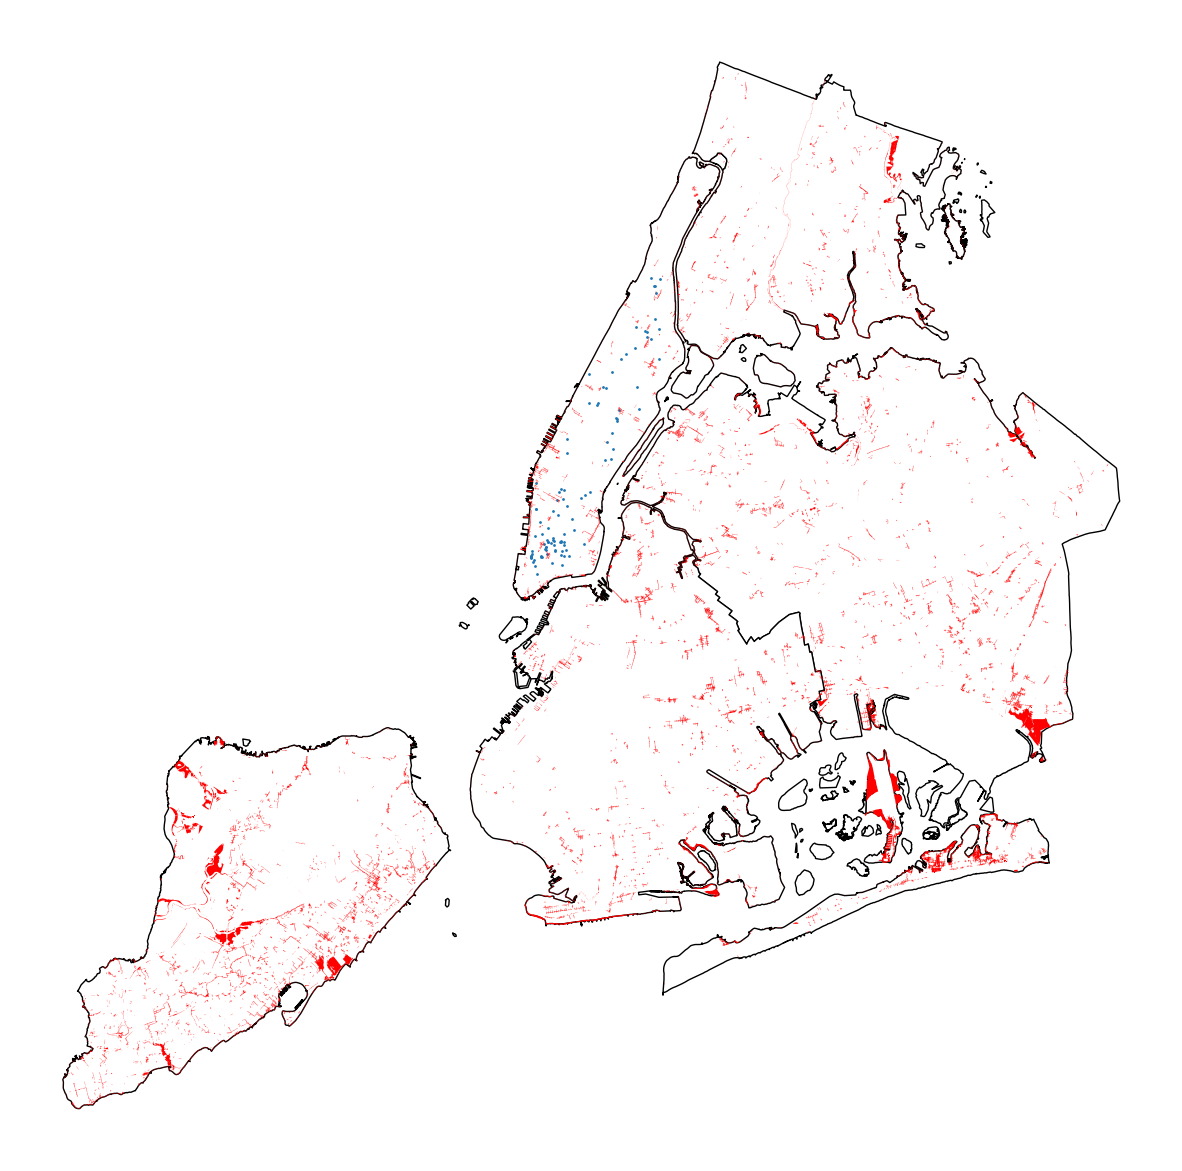

In [2]:
import geopandas
from geodatasets import get_path
import matplotlib.pyplot as plt

# ------------------------
# Map the boroughs

path_to_data = get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf = gdf.set_index("BoroName")

base = gdf.plot(figsize=(15, 15), color='white', edgecolor='black', linewidth=1)
base.set_axis_off()

# ------------------------
# Map housing

gdf2 = geopandas.read_file(
  "housingData/HousingDB_post2010.shp",
  rows=100 # TODO Update this value once filtering is working
)

'''
TODO
- Filter out demolitions and alterations
'''

gdf2.plot(ax=base, markersize=1)

# ------------------------
# Part 3: Map flood risk areas in 2050

gdf3 = geopandas.read_file('floodMapData2050.gdb')
gdf3.plot(ax=base, color='red')

breakpoint()

plt.savefig('images/newHousingMap', dpi=200)

# ------------------------
# Part 4: Break flood risks out by type and map separately